# Data Challenge 2 - Reorder Sentences

Submitted by: Siqi Liu

Student ID: 20428295

WatIAm: sq2liu

## Set-Up

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sentence-ordering')

In [31]:
!pip install transformers==4.2.2

In [32]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler

In [33]:
from src import config
from src import data
from src import graph
from src import model
from src import utils

In [34]:
from importlib import reload

def reload_all():
  reload(config)
  reload(data)
  reload(graph)
  reload(model)
  reload(utils)

In [35]:
device = utils.get_device()

Current device: cuda


In [38]:
config.args

{'dir': '/content/drive/MyDrive/Colab Notebooks/sentence-ordering/',
 'do_lower_case': False,
 'graph_method': 'max_flow',
 'labeled_filename': 'data/train.pkl',
 'model_fsent': {'adam_eps': 1e-08,
  'batch_size': 32,
  'lr': 5e-05,
  'max_length': 64,
  'num_epochs': 5,
  'num_train_samples': 10000,
  'target_ratio': 0.5,
  'warmup_steps': 0},
 'model_output_dir': 'trained/',
 'model_pair': {'adam_eps': 1e-08,
  'batch_size': 32,
  'lr': 5e-05,
  'max_length': 128,
  'num_epochs': 30,
  'num_train_samples': 10000,
  'warmup_steps': 0},
 'model_type': 'bert-base-multilingual-cased',
 'num_train_docs': 100000,
 'num_val_docs': 500,
 'pred_filename': 'data/test.pkl',
 'seed': 647}

## Data

In [39]:
labeled_set = data.load_dataset(config.args['dir'] + config.args['labeled_filename'])
pred_set = data.load_dataset(config.args['dir'] + config.args['pred_filename'])

/content/drive/MyDrive/Colab Notebooks/sentence-ordering/data/train.pkl loaded. Size: 590226
/content/drive/MyDrive/Colab Notebooks/sentence-ordering/data/test.pkl loaded. Size: 2000


In [40]:
train_set, val_set = data.get_train_val_set(
    labeled_set,
    config.args['num_val_docs'],
    config.args['num_train_docs']
)

train_set size: 100000
val_set size: 500


In [41]:
tokenizer = model.load_tokenizer()

## First Sentence Model

### Create Datasets, Samplers and DataLoaders

In [42]:
train_dataset_fsent = data.FirstSentenceDataset(train_set, tokenizer, config.args['model_fsent']['max_length'])
val_dataset_fsent = data.FirstSentenceDataset(val_set, tokenizer, config.args['model_fsent']['max_length'])

Dataset loaded. Size: 600000
Dataset loaded. Size: 3000


In [43]:
train_weights_fsent, weight_one_fsent = data.get_weights_for_balanced_classes(
    train_dataset_fsent,
    target_ratio=config.args['model_fsent']['target_ratio']
)

train_sampler_fsent = WeightedRandomSampler(
    weights=train_weights_fsent,
    num_samples=config.args['model_fsent']['num_train_samples'],
    replacement=False
)

val_sampler_fsent = SequentialSampler(
    data_source=val_dataset_fsent
)

Weight for Ones: 5.0000


In [44]:
dataset_sizes_fsent = {
    'train' : config.args['model_fsent']['num_train_samples'],
    'val' : len(val_dataset_fsent),
}

print('train Dataset size: {:d}\nval Dataset size: {:d}'.format(
    dataset_sizes_fsent['train'], dataset_sizes_fsent['val']
))

train Dataset size: 10000
val Dataset size: 3000


In [45]:
train_dataloader_fsent = DataLoader(
    train_dataset_fsent,
    sampler=train_sampler_fsent,
    batch_size=config.args['model_fsent']['batch_size']
)

val_dataloader_fsent = DataLoader(
    val_dataset_fsent,
    sampler=val_sampler_fsent,
    batch_size=config.args['model_fsent']['batch_size']
)

In [46]:
dataloaders_fsent = {
    'train' : train_dataloader_fsent,
    'val' : val_dataloader_fsent
}

print('train DataLoader size: {:d}\nval DataLoader size: {:d}'.format(
    len(dataloaders_fsent['train']), len(dataloaders_fsent['val'])
))

train DataLoader size: 313
val DataLoader size: 94


### Load Pre-Trained Model

In [47]:
model_fsent = model.load_model()

# model_fsent = torch.load('{:s}fsent_model_checkpoint.pt'.format(
#     config.args['dir'] + config.args['model_output_dir']
# ))

model_fsent.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Initialize Optimizer and Scheduler

In [48]:
optimizer_fsent = model.get_optimizer(
    model_fsent,
    config.args['model_fsent']['lr'],
    config.args['model_fsent']['adam_eps']
)

In [49]:
scheduler_fsent = model.get_scheduler(
    optimizer_fsent,
    config.args['model_fsent']['warmup_steps'],
    len(train_dataloader_fsent) * config.args['model_fsent']['num_epochs']
)

### Train Model

In [50]:
model_fsent, best_epoch_fsent, losses_fsent, accuracies_fsent = model.train_fsent(
    model=model_fsent,
    device=device,
    dataloaders=dataloaders_fsent,
    dataset_sizes=dataset_sizes_fsent,
    optimizer=optimizer_fsent,
    scheduler=scheduler_fsent,
    num_epochs=config.args['model_fsent']['num_epochs']
)

Epoch 1/5
----------



train Loss: 0.1532; Acc: 0.9499



val Loss: 0.1881; Acc: 0.9387
Best model so far! Saved checkpoint.

Epoch 2/5
----------



train Loss: 0.1152; Acc: 0.9666



val Loss: 0.0558; Acc: 0.9837
Best model so far! Saved checkpoint.

Epoch 3/5
----------



train Loss: 0.0901; Acc: 0.9734



val Loss: 0.0685; Acc: 0.9777

Epoch 4/5
----------



train Loss: 0.0831; Acc: 0.9756



val Loss: 0.0499; Acc: 0.9833

Epoch 5/5
----------



train Loss: 0.0761; Acc: 0.9760



val Loss: 0.0596; Acc: 0.9827

Training complete in 10m 35s
Best Val Acc: 0.983667 at Epoch: 1


### Plots

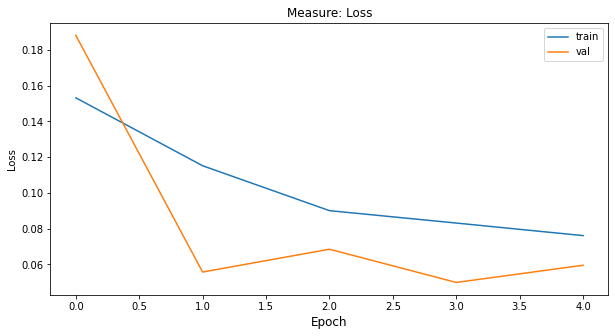

In [51]:
utils.plot_statistics("Loss", losses_fsent)

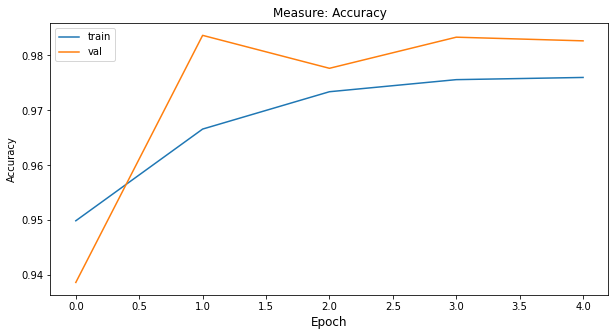

In [52]:
utils.plot_statistics("Accuracy", accuracies_fsent)

## Pairwise Model

### Create Training Dataset, Sampler and DataLoader

In [53]:
train_dataset_pair = data.SentencePairDataset(train_set, tokenizer, config.args['model_pair']['max_length'])

Dataset loaded. Size: 1500000


In [54]:
# should be around 0.5
np.mean(train_dataset_pair.labels)

0.500198

In [55]:
train_sampler_pair = RandomSampler(
    data_source=train_dataset_pair,
    num_samples=config.args['model_pair']['num_train_samples'],
    replacement=True
)

In [56]:
train_dataloader_pair = DataLoader(
    train_dataset_pair,
    sampler=train_sampler_pair,
    batch_size=config.args['model_pair']['batch_size']
)

### Load Pre-Trained Model

In [57]:
model_pair = model.load_model()

# model_pair = torch.load('{:s}pair_model_checkpoint.pt'.format(
#     config.args['dir'] + config.args['model_output_dir']
# ))

model_pair.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

### Initialize Optimizer and Scheduler

In [58]:
optimizer_pair = model.get_optimizer(
    model_pair,
    config.args['model_pair']['lr'],
    config.args['model_pair']['adam_eps']
)

In [59]:
scheduler_pair = model.get_scheduler(
    optimizer_pair,
    config.args['model_pair']['warmup_steps'],
    len(train_dataloader_pair) * config.args['model_pair']['num_epochs']
)

### Train Model

In [ ]:
model_pair, best_epoch_pair, losses_pair, accuracies_pair, spearmans_pair = model.train_pair(
    model=model_pair,
    model_fsent=model_fsent,
    tokenizer=tokenizer,
    device=device,
    val_set=val_set,
    train_dataloader=train_dataloader_pair,
    optimizer=optimizer_pair,
    scheduler=scheduler_pair,
    num_epochs=config.args['model_pair']['num_epochs']
)

Epoch 1/30
----------



train Loss: 0.4424; Acc: 0.7754



Best model so far! Saved checkpoint.

Epoch 2/30
----------



train Loss: 0.3923; Acc: 0.8100



Best model so far! Saved checkpoint.

Epoch 3/30
----------



train Loss: 0.3878; Acc: 0.8146



Best model so far! Saved checkpoint.

Epoch 4/30
----------



train Loss: 0.3837; Acc: 0.8147




Epoch 5/30
----------



train Loss: 0.3798; Acc: 0.8185




Epoch 6/30
----------



train Loss: 0.3704; Acc: 0.8217




Epoch 7/30
----------



train Loss: 0.3653; Acc: 0.8196



Best model so far! Saved checkpoint.

Epoch 8/30
----------



train Loss: 0.3672; Acc: 0.8196




Epoch 9/30
----------



train Loss: 0.3616; Acc: 0.8262




Epoch 10/30
----------



train Loss: 0.3546; Acc: 0.8270




Epoch 11/30
----------



train Loss: 0.3394; Acc: 0.8380




Epoch 12/30
----------



train Loss: 0.3449; Acc: 0.8342




Epoch 13/30
----------



train Loss: 0.3422; Acc: 0.8390




Epoch 14/30
----------



train Loss: 0.3344; Acc: 0.8434




Epoch 15/30
----------



train Loss: 0.3421; Acc: 0.8363




Epoch 16/30
----------



train Loss: 0.3309; Acc: 0.8435



Best model so far! Saved checkpoint.

Epoch 17/30
----------



train Loss: 0.3257; Acc: 0.8494


### Plots

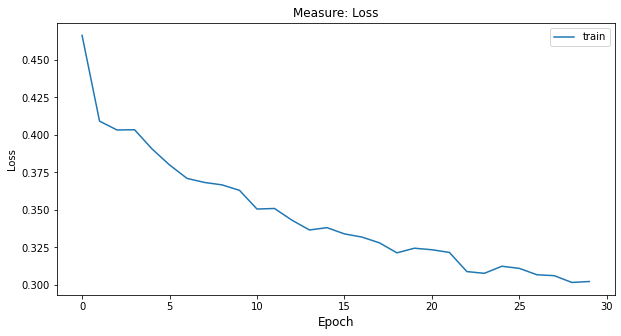

In [ ]:
utils.plot_statistics("Loss", losses_pair)

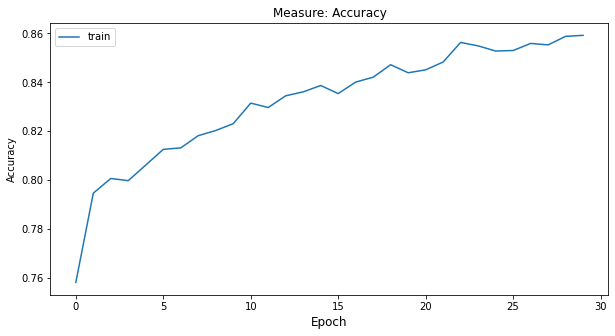

In [ ]:
utils.plot_statistics("Accuracy", accuracies_pair)

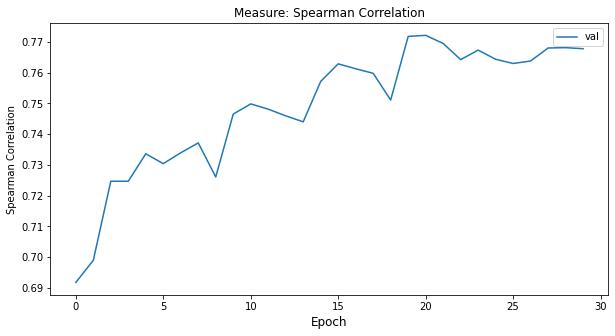

In [ ]:
utils.plot_statistics("Spearman Correlation", spearmans_pair)

## Example

In [ ]:
doc = val_set[53]

doc

{'ID': 390043,
 'indexes': [5, 3, 1, 4, 2, 0],
 'sentences': ['The first decade of freedom brought mainly state reforms in the financing of cultural institutions and patronage; forcing self-sustainability in an often uncharted territory.',
  'However, unlike any other temporal marker in the development of Polish culture from the past, the year 1989 did not introduce any specific literary events or artistic manifestations.',
  'After 1989, the heavy government controls ended, and the radical economic changes were introduced.',
  'For a generation of accomplished writers the objectives and their moral quests remained the same as in the preceding period.',
  'The influx of new aesthetic and social ideas was accompanied by the Western market forces.',
  'With the fall of communism Polish culture and society began a process of profound transformation, marked by the return of democracy and redevelopment of civil society.']}

In [ ]:
# predict first sentence position
fsent_pos = model.predict_fsent_pos(doc, device, model_fsent, tokenizer)

fsent_pos

In [ ]:
# predict sentence pairs logits
pair_logits = model.predict_pair_logits(doc, device, model_pair, tokenizer)

pair_logits

[(0, 1, array([0.48957336, 0.21545903], dtype=float32)),
 (0, 2, array([-1.6583006,  1.5283937], dtype=float32)),
 (0, 3, array([-0.7538838 ,  0.93855476], dtype=float32)),
 (0, 4, array([-1.4876704,  1.4266177], dtype=float32)),
 (0, 5, array([0.6288749 , 0.07715879], dtype=float32)),
 (1, 2, array([-0.06474896,  0.5195623 ], dtype=float32)),
 (1, 3, array([-0.7233316,  0.8974521], dtype=float32)),
 (1, 4, array([-0.9056027,  1.0052422], dtype=float32)),
 (1, 5, array([0.32284626, 0.28064442], dtype=float32)),
 (2, 3, array([0.01453727, 0.44684926], dtype=float32)),
 (2, 4, array([-0.30494058,  0.6601622 ], dtype=float32)),
 (2, 5, array([ 1.0755972 , -0.22942127], dtype=float32)),
 (3, 4, array([-0.21395342,  0.6267095 ], dtype=float32)),
 (3, 5, array([ 0.9824548 , -0.13982956], dtype=float32)),
 (4, 5, array([ 1.3044883 , -0.38286954], dtype=float32))]

In [ ]:
# construct graph based on predictions
num_vertices = len(doc['sentences'])
g = model.make_graph(num_vertices, pair_logits)

g.graph

[[None, 0.21545903, 1.5283937, 0.93855476, 1.4266177, 0.07715879],
 [0.48957336, None, 0.5195623, 0.8974521, 1.0052422, 0.28064442],
 [-1.6583006, -0.06474896, None, 0.44684926, 0.6601622, -0.22942127],
 [-0.7538838, -0.7233316, 0.0145372655, None, 0.6267095, -0.13982956],
 [-1.4876704, -0.9056027, -0.30494058, -0.21395342, None, -0.38286954],
 [0.6288749, 0.32284626, 1.0755972, 0.9824548, 1.3044883, None]]

In [ ]:
# sort and get the order
if config.args['graph_method'] == 'max_flow':
    order, weight = g.max_flow(fsent_pos)
elif config.args['graph_method'] == 'greedy':
    order, weight = g.greedy(fsent_pos)
else:
    raise InvalidInputError()

order, weight

([5, 1, 0, 2, 3, 4], 12.853378653526306)

In [ ]:
indexes = [-1] * num_vertices
for p, o in enumerate(order):
    indexes[o] = p

indexes

[2, 1, 3, 4, 5, 0]

## Submission

In [ ]:
submission = model.predict_submission(pred_set, device, model_fsent, model_pair, tokenizer)

submission

,ID,index1,index2,index3,index4,index5,index6
0,1,1,5,3,2,4,0
1,2,4,2,3,0,1,5
2,3,3,1,2,0,4,5
3,4,3,0,2,1,4,5
4,5,3,2,4,0,1,5
...,...,...,...,...,...,...,...
1995,1996,0,1,2,3,4,5
1996,1997,2,3,4,5,0,1
1997,1998,2,5,4,3,0,1
1998,1999,3,1,2,4,5,0


In [ ]:
submission.to_csv(config.args['dir'] + 'submission.csv', index=False)